In [20]:
# from kaggle.api.kaggle_api_extended import KaggleApi
import os
import shutil, os

# api = KaggleApi()
# api.authenticate()

DATA_DIR   = 'data'
TARGET_DIR = 'data/16_animes'

In [21]:
# DATA_DIR = 'data'
# if not os.path.exists(DATA_DIR):
#     os.makedirs(DATA_DIR)
#     api.dataset_download_files('diraizel/anime-images-dataset', path=DATA_DIR, unzip=True)

In [22]:
import shutil, os
os.makedirs(TARGET_DIR, exist_ok=True)

all_animes = sorted(os.listdir(DATA_DIR))
print(all_animes) 

['16_animes']


In [23]:
selected = [
    'AKIRA',
    'Attack on Titan',
    'Cardcaptor Sakura',
    'Fullmetal Alchemist Brotherhood',
    'Dragon Ball Z',
    'Death Note',
    'Haikyu!!',
    'My Hero Academia',
    'Hunter x Hunter',
    'Nana',
    'Nanatsu no Taizai',
    'Naruto',
    'Yu Yu Hakusho',
    'Your Name',
    'Violet Evergarden',
    'One Piece',
]

# os.makedirs(TARGET_DIR, exist_ok=True)

# for anime in selected:
#     src = os.path.join(DATA_DIR, anime)
#     dst = os.path.join(TARGET_DIR, anime)
#     shutil.copytree(src, dst)


## Treinamento do modelo

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

In [25]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

train_gen = train_datagen.flow_from_directory(
    'data/16_animes',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    'data/16_animes',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 4740 images belonging to 16 classes.
Found 1181 images belonging to 16 classes.


In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D

initializer = HeUniform()

model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer=initializer, input_shape=IMG_SIZE + (3,)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer=initializer),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer=initializer),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu', kernel_initializer=initializer),
    Dropout(0.4),
    Dense(train_gen.num_classes, activation='softmax')  # Certo pra classificação multi-classe
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,720 (440.31 KB)

 Trainable params: 112,272 (438.56 KB)

 Non-trainable params: 448 (1.75 KB)

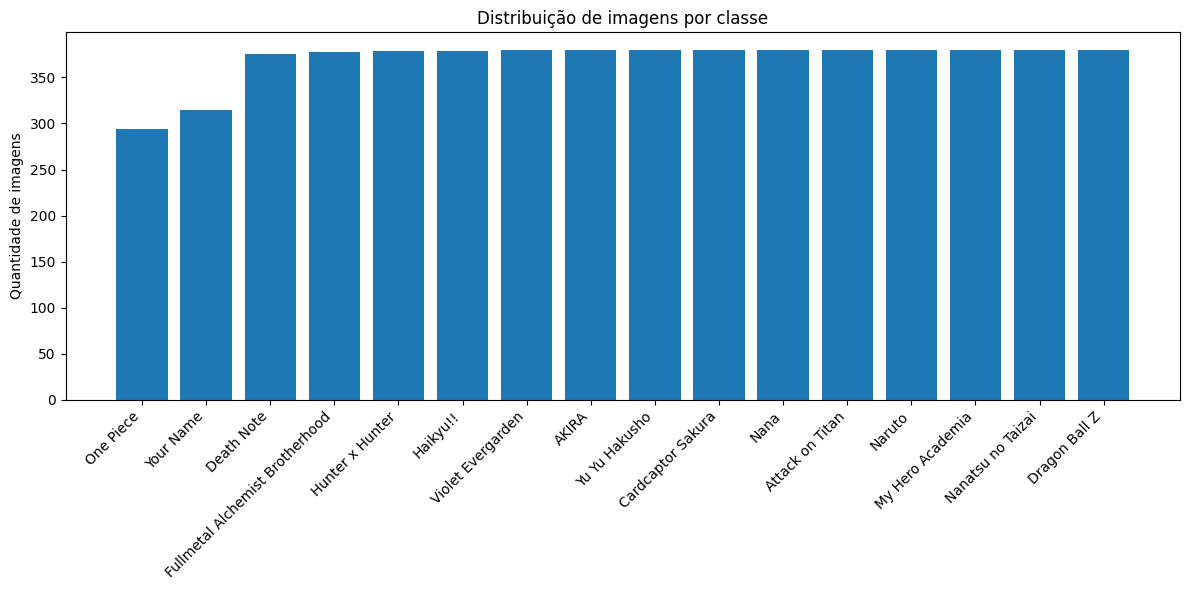

In [31]:
import os
import matplotlib.pyplot as plt

base_path = 'data/16_animes'
counts = {}

for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)
    if os.path.isdir(folder_path):
        num_images = len([
            f for f in os.listdir(folder_path)
            if f.lower().endswith(('.jpg', '.png', '.jpeg'))
        ])
        counts[folder] = num_images

# Agora sim, esse bloco usa o counts corretamente:
labels, values = zip(*sorted(counts.items(), key=lambda x: x[1]))

plt.figure(figsize=(12, 6))
plt.bar(labels, values)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Quantidade de imagens')
plt.title('Distribuição de imagens por classe')
plt.tight_layout()
plt.show()


In [28]:
batch_x, batch_y = next(train_gen)
print("Shape de uma imagem:", batch_x[0].shape)

Shape de uma imagem: (128, 128, 3)


In [34]:
EPOCHS = 30  # você pode aumentar depois

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)

Epoch 1/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.0899 - loss: 3.7182 - val_accuracy: 0.0864 - val_loss: 2.7374
Epoch 2/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.1146 - loss: 3.0729 - val_accuracy: 0.1473 - val_loss: 2.5918
Epoch 3/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.1329 - loss: 2.9240 - val_accuracy: 0.2295 - val_loss: 2.4197
Epoch 4/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.1440 - loss: 2.9006 - val_accuracy: 0.2794 - val_loss: 2.3122
Epoch 5/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.1580 - loss: 2.8558 - val_accuracy: 0.2794 - val_loss: 2.2966
Epoch 6/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.1626 - loss: 2.8289 - val_accuracy: 0.3082 - val_loss: 2.2662
Epoch 7/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.1671 - loss: 2.7990 - val_accuracy: 0.3099 - val_loss: 2.2556
Epoch 8/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.1822 - loss: 2.7438 - val_acc